In [2]:
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Linear Prediction

We are going to generate a signal and sample it at 10kHz for a time interval of 10ms.
This means that, at that sampling frequency, we have 100 samples in 10ms.

The $sin$ and $cos$ functions accept arguments in radians. So we have to convert frequency from Hz to rad/s with the formula $\omega = 2\pi f$, where $\omega$ is the frequency in rad/s.



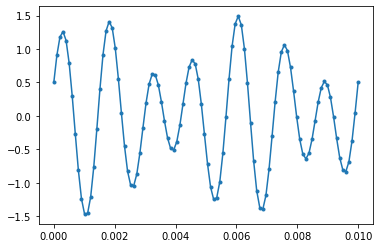

In [5]:
t = linspace(0, 0.01, 100)                        # 0 to 10ms with 100 samples
x = sin(2*pi*700*t) + 0.5*cos(2*pi*500*t)         # our signal
plot(t, x,'.-');

# Finding a 2nd order linear predictor

A 2nd order linear predictor is given by
$$
\hat x_t = a_1 x_{t-1} + a_2 x_{t-2}
$$
where $x_t$ are the data from the signal and $a_1,a_2$ are the predictor parameters.
To find the parameters, we minimize the sum of squared errors
$$\begin{split}
E(a_1,a_2) &= \sum_t (\hat x_t - x_t)^2 \\
&= \sum_t (a_1 x_{t-1} + a_2 x_{t-2} - x_t)^2.
\end{split}$$
We minimize $E(a_1,a_2)$ with respect to the parameters setting the partial derivatives to zero (stationarity conditions). Since the function is convex by definition, the stationarity conditions are sufficient.
$$\begin{split}
a_1 \sum_{t=3}^N x_{t-1}x_{t-1} + a_2\sum_{t=3}^N x_{t-2}x_{t-1} - \sum_{t=3}^N x_t x_{t-1} = 0 \\
a_1 \sum_{t=3}^N x_{t-1}x_{t-2} + a_2\sum_{t=3}^N x_{t-2}x_{t-2} - \sum_{t=3}^N x_t x_{t-2} = 0.
\end{split}$$
Putting this to the matrix equation
$$
\begin{bmatrix}R_{11} & R_{12}\\ R_{21}&R_{22}\end{bmatrix}\begin{bmatrix}a_1\\a_2\end{bmatrix} = \begin{bmatrix}R_1\\R_2\end{bmatrix}
$$
and solving to the parameters $a_1,a_2$ leads to the optimal predictor.

In [179]:
R00 = sum(x[1:99]**2)          # sum_t x(t-1)x(t-1) 
R01 = sum(x[0:98] * x[1:99])   # sum_t x(t-2)x(t-1)
R10 = R01
R11 = sum(x[0:98]**2)          # sum_t x(t-2)x(t-2)
r1 = sum(x[2:100] * x[1:99])
r2 = sum(x[2:100] * x[0:98])

R = array([R00, R01, R10, R11]).reshape(2,2)  # square matrix
r = array([r1, r2])
a = solve(R, r)
print('The parameters are: ', a)

The parameters are:  [ 1.81905776 -0.99416053]


# "Reconstructing" the signal

To synthesize the signal, we are going to use the first two samples from $x_t$ and the predictor parameters
$a_1,a_2$.
This is done by iteratively applying the predictor to the two previously generated values.
Hopefully, this will be close to the original signal.

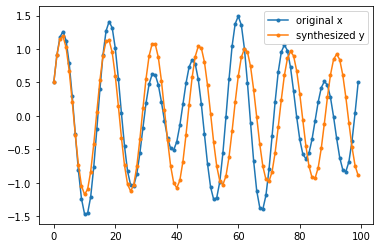

In [167]:
y = zeros(100)
y[:2] = x[:2]
for t in range(2, 100):
    y[t] = a[0]*y[t-1] + a[1]*y[t-2]
plot(x, '.-')
plot(y, '.-')
legend(['original x', 'synthesized y']);

# General solution

An n-th order predictor is given by
$$
\hat x_t = a_1x_{t-1} + a_2x_{t-2} + \cdots + a_Nx_{t-N} = \sum_{n=1}^N a_n x_{t-n}.
$$
The prediction error (sum of squares) is then
$$
E(a_1,\ldots,a_N) = \sum_{t=1}^T (x_t - \hat x_t)^2
$$
To find the optimal parameters we minimize $E$ with respect to $a_n$, $n=1,\ldots,N$. 
As before, this is done by make the partial derivatives equal to zero $\frac{\partial E}{\partial a_j}=0$ for all $j=1,\ldots,N$.

The $N$ partial derivatives are given by
$$\begin{split}
\frac{\partial E}{\partial a_j} &= -2\left(\sum_{t=1}^T x_tx_{t-j}\right) + 2\sum_{i=1}^N a_i \left(\sum_{t=1}^T x_{t-i}x_{t-j}\right),\qquad j=1,\ldots,N. 
\end{split}$$
Which when set to zero to zero yields the equation
$$
\sum_{i=1}^N a_i \left(\sum_{t=1}^T x_{t-i}x_{t-j}\right) = \sum_{t=1}^T x_tx_{t-1},\qquad j=1,\ldots,N. 
$$
This can be written in the form of a matrix equation where the elements of the matrices are the expressions that depend only on the data $x_t$ and the vector of unknowns contains the parameters $a_i$. Let
$$
R_{ij} = \sum_{t=1}^T x_{t-i}x_{t-j}, \qquad R_i = \sum_{t=1}^T x_tx_{t-j},
$$
then we have can write
$$
\begin{bmatrix}
R_{11} & R_{12} & \cdots & R_{1N}\\
R_{21} & R_{22} & \cdots & R_{2N}\\
\vdots & \vdots & \ddots & \vdots\\
R_{N1} & R_{N2} & \cdots & R_{NN}
\end{bmatrix}\begin{bmatrix}a_1\\a_2\\\vdots\\a_N\end{bmatrix}=\begin{bmatrix}R_1\\R_2\\\vdots\\R_N\end{bmatrix}.
$$
At this point, the system of equations can be solved and the Nth order predictor parameters found, but we can do a little better by taking advantage of some properties that facilitate the computation complexity required to find
the solution.
The first thing that we see is that $R_{ij}=R_{ji}$ and so the matrix is symmetric.


<!-- The other thing is that $R_{ij}$ actually only depends on the difference between $i$ and $j$. -->



# Find Nth order linear predictor
**author**: @rubenteimas

In [7]:
# general expression for symmetric matrix
#[i][j] => [j][i] <=> i*j + i+j

def build_nxn_matrix(n: int, new_matrix: np.ndarray, signal_points: np.ndarray) -> list:
    signal_sample_size = len(signal_points) - 1 # -1 to adjust to index
    n = n - 1 # -1 to adjust index
    
    for i in range(n):
        for j in range(n):
            if i < j:
                new_matrix[i][j] = new_matrix[j][i]
            else:
                x_ti = x[(n-i):(signal_sample_size-i)]
                x_tj = x[(n-j):(signal_sample_size-j)]
                new_matrix[i][j] = sum(x_ti * x_tj)
                
    return new_matrix
                

In [8]:
def build_vector(n: int, new_vector: np.ndarray, signal_sample: np.ndarray) -> list:
    signal_sample_size = len(signal_sample)
    
    for i in range(n):
        new_vector[i] = sum(x[n:signal_sample_size] * x[n-1-i:signal_sample_size-1-i]) 
    
    return new_vector

In [9]:
def nth_order_predictor(n: int, signal_sample: np.ndarray) -> list:
    empty_matrix = np.empty(shape=(n,n))
    empty_vector = np.empty(shape=(n,))
    
    matrix = build_nxn_matrix(n, empty_matrix, signal_sample)
    vector = build_vector(n, empty_vector, signal_sample)
    
    weights = solve(matrix, vector)
    
    return weights

In [10]:
w = nth_order_predictor(3, x)
print(w)

[ 0.90340964 -0.16264837 19.13290716]


# Levinson-Durbin algorithm

In [ ]:
def lev